# Lab 2 -- Feedforward Network and Backpropagation

Objectives:
1. *Understand backpropagation*
2. *Write a neural network with one or more hidden layers*
3. *Solve the XOR*
4. *Understand how to build general classifiers*

During the previous lab we noticed that a single neuron is not able to solve a non-linearly separable problem like the XOR. In this class we will expand the capabilities of our initial network, will move beyond a single neuron and we will solve arbitrarily complex datasets.

We want to create a network with the following structure:

<center><img src="https://i.imgur.com/wEtR8Jg.png" height="250"></center>

$$s = \vec{w}^T\vec{x}+b$$
$$\sigma(s) = \frac{1}{1+e^{-s}}$$

In [74]:
# Start by importing the library Numpy
import numpy as np

# Create training set.
X = np.random.randint(2, size=[50,2])
Z = np.array([X[:,0] ^ X[:, 1]]).T

# Modify the way weights and bases are initialised
W1 = np.random.randn(3,2)
B1 = np.random.randn(3)
W2 = np.random.randn(1,3)
B2 = np.random.randn(1)

*Can you explain why we set the dimensions of the weights as (3,2) and (1,3)?*

`W1` is the matrix of weights for the first layer, which has 3 neurons, each with 2 inputs. `W2` is the matrix of weights for the second layer, containing only 1 neuron that has 3 inputs.

In [75]:
# Add a forward function to reflect the network topology that we want to replicate

def sigm(X, W, B):
    M = 1/(1+np.exp(-(X.dot(W.T)+B)))
    return M

def Forward(X, W1, B1, W2, B2):
    H = sigm(X,W1,B1) # first layer
    Y = sigm(H,W2,B2) # second layer

    # Return both final and hidden layer output
    return Y, H

Due to the presence of the hidden layer, we need to use the backpropagation algorithm to update the weights.

$$E = (z-y)^2 \\[0.5em]
w_i^\prime = w_i + \eta\frac{dE}{dw_i} \\[0.5em]
b^\prime = b+\eta\frac{dE}{db}
$$

where $z$ is the correct output, $y$ is the current output of the neuron and $\eta$ is the learning rate.

*Try and derive an analytical expression for the update of the weights.*

$s = w_{2,1}h_1 + w_{2,2}h_2 + w_{2,3}h_3 + b_2$

For the second layer: let $y$ = $\sigma(s)$

- First working out `diff_W2`

\begin{split}
    \frac{dE}{dw_{2,i}}
    &= \frac{\partial E}{\partial y} * \frac{\partial y}{\partial s} * \frac{\partial s}{\partial w_{2,i}} \\
    &= -2(z-y) *  y(1-y) * x_{2,i} \\
    &= -2(z-y) *  y(1-y) * h_i
\end{split}

- Then `diff_B2`

\begin{split}
    \frac{dE}{db_2}
    &= \frac{\partial E}{\partial y} * \frac{\partial y}{\partial s} * \frac{\partial s}{\partial b_2} \\
    &= -2(z-y) * y(1-y) * 1
\end{split}

For the first layer: current neuron output now becomes $h_i = \sigma(\bar{h}_i)$

- Deriving `diff_W1`

$$\frac{dE}{dw_{1,i}}
= \frac{\partial E}{\partial \bar{h}_i} * \frac{\partial \bar{h}_i}{\partial w_{1,1}}
= \frac{\partial E}{\partial \bar{h}_i} * x_{1,i}$$

$$\frac{\partial E}{\partial \bar{h}_i}
= \frac{\partial E}{\partial h_i} * \frac{\partial h_i}{\partial \bar{h}_i}
= \frac{\partial E}{\partial h_i} *  h_i(1-h_i)$$

$$\frac{\partial E}{\partial h_i}
= \frac{\partial E}{\partial s} * \frac{\partial s}{\partial h_i}
= \frac{\partial E}{\partial s} * w_{2,i}$$

$$\frac{\partial E}{\partial s} = \frac{\partial E}{\partial y} * \frac{\partial y}{\partial s} = -2(z-y)*y(1-y)$$

- Plugging everything back in gives

$$\frac{dE}{dw_{1,i}} = x_{1,i} * -2(z-y) * w_{2,i} * y(1-y) * h_i(1-h_i)$$

- Deriving `diff_B1`

$$\frac{dE}{db_1} = \frac{dE}{dw_{1,i}} \div x_{1,i} = -2(z-y) * w_{2,i} * y(1-y) * h_i(1-h_i)$$

In [76]:
# Write the code for the updates of the various parameters

def diff_B2(Z, Y):
    dB = (Z-Y)*Y*(1-Y)
    return dB.sum(axis=0)

def diff_W2(H, Z, Y): 
    dW = (Z-Y)*Y*(1-Y)
    return H.T.dot(dW)

def diff_W1(X, H, Z, Y, W2):
    dZ = (Z-Y).dot(W2)*Y*(1-Y)*H*(1-H)
    return X.T.dot(dZ)

def diff_B1(Z, Y, W2, H):
    return ((Z-Y).dot(W2)*Y*(1-Y)*H*(1-H)).sum(axis=0)

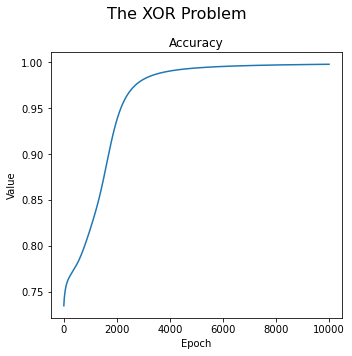

In [77]:
import matplotlib.pyplot as plt

learning_rate = 0.01
acc_val = []

num_epochs = 10000

for epoch in range(num_epochs):
    Y, H = Forward(X, W1, B1, W2, B2)
    
    # Notice that we are not making use of the sigmoid function inside the update rules.
    # Instead, we feed them the outputs from the middle layer (H, in this specific example).
    
    W2 += learning_rate * diff_W2(H, Z, Y).T
    B2 += learning_rate * diff_B2(Z, Y)
    W1 += learning_rate * diff_W1(X, H, Z, Y, W2).T
    B1 += learning_rate * diff_B1(Z, Y, W2, H)

    accuracy = 1 - np.mean((Z - Y)**2)
    acc_val += [accuracy]

fig, ax1 = plt.subplots(1,1,figsize=(5,5))
fig.suptitle('The XOR Problem', fontsize=16)

ax1.plot(acc_val)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Value')
ax1.set_title('Accuracy')

fig.tight_layout()
plt.show()